<a href="https://colab.research.google.com/github/Subarna-kanti/Real-time-Dress-Recognition-Paradigm/blob/master/Yolo%2Bclassifier(Test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from keras.models import load_model
import time 
from IPython import display

Using TensorFlow backend.


In [ ]:
classifier_model = load_model("/content/drive/My Drive/Models_DressC/dress_classifier_weights.h5")


In [ ]:
dic = { 0 : "kurti" ,										
1 : "saree", 										
2 : "formal shirt", 										
3 : "T-shirt" 
}		

In [ ]:
# create a YOLOv3 Keras model and save it to file
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import cv2
import pickle 



In [ ]:
# load yolov3 model and perform object detection
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import shutil
import os
#The output of the model is, in fact, encoded candidate bounding boxes from three different grid sizes, and the boxes are defined the context of anchor boxes
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def do_nms(boxes, nms_thresh):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores


# load yolov3 model
model = load_model('/content/drive/My Drive/Models_DressC/Yolo_pretrained_model.h5')


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


In [ ]:
def common_element(a , b): 
  a_set = set(a)
  b_set = set(b)
  if len(a_set.intersection(b_set))> 0:
    return(list(a_set.intersection(b_set)))
  else:
    return 0 

In [ ]:
def zeropad_images(image, req_scale = 128):
  h , w , c = image.shape 
  print(image.shape)
  if w >= req_scale or h >= req_scale: 
    if w > h : 
      image = cv2.resize(image, dsize = (req_scale , int(req_scale*(h/w))   ), interpolation=cv2.INTER_CUBIC)
    if h > w : 
      image = cv2.resize(image, dsize = ( int(req_scale*(w/h)) , req_scale  ), interpolation=cv2.INTER_CUBIC)
  width_pad, height_pad = 0 , 0 
  h , w , c = image.shape 
  if h < req_scale : 
    height_pad = int((req_scale - h)/2)
  if w < req_scale : 
    width_pad = int((req_scale - w)/2)
  image = np.pad(image, ((height_pad, height_pad), (width_pad, width_pad), (0,0) ), mode = 'constant')
  image = cv2.resize(image, dsize = (req_scale , req_scale   ), interpolation=cv2.INTER_CUBIC)
  return image

In [ ]:
def draw_boxes(filename, v_boxes, v_labels, v_scores, dir_labels, dress_dataframe = None):
  data = pyplot.imread(filename)
  req_scale = 128
  dress_labels = [i for i in v_labels if i == 'person']
  j = 0 
  label_name = common_element(filename.split('/') , dir_labels)[0]
  pyplot.imshow(data)
  ax =  pyplot.gca()

  correct_or_incorrect_label = []
  for i in range( len(v_boxes)):
    if v_labels[i] == 'person':  
      box = v_boxes[i]
      y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
      width, height = x2 - x1 , y2 - y1
      temp = data[y1: y2, x1 : x2 ]

      rect = Rectangle((x1, y1), width, height, fill=False, color='red')

      temp = zeropad_images(temp, req_scale)
      prediction = classifier_model.predict(np.expand_dims(temp, axis = 0))
      pred = np.argmax(prediction, axis = 1)
      pred_label = dic[pred[0]]

      if pred_label == label_name: 
        correct_or_incorrect_label.append(1)
      else:
        correct_or_incorrect_label.append(0)

      ax.add_patch(rect)
      label = "%s" % (v_labels[i] + " wearing " + pred_label )
      pyplot.text(x1, y1, label, color='red', fontsize = 12)
    else:
       continue
  pyplot.show()
  
  return correct_or_incorrect_label

In [ ]:
def yolo_person_seperator(path , dress_labels, dress_dataframe = None ):
  input_w, input_h = 416, 416
  # define our new photo
  photo_filename = path
  # load and prepare image
  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
  # make prediction
  yhat = model.predict(image)
  # summarize the shape of the list of arrays
  # print([a.shape for a in yhat])
  # define the anchors
  anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
  # define the probability threshold for detected objects
  class_threshold = 0.6
  boxes = list()
  for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
  # suppress non-maximal boxes
  do_nms(boxes, 0.5)

  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
  correct_incorrect_pred = draw_boxes(photo_filename, v_boxes, v_labels, v_scores , dress_labels )
  return correct_incorrect_pred

(287, 93, 3)


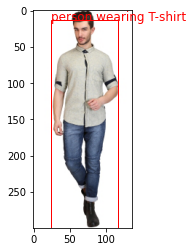

--- Model takes 6.608034610748291 second to predict ---


In [ ]:
correct_or_incorrect_pred = np.array([ ])
temp = np.array([])
test_loc = "/content/drive/My Drive/test_submit_dress_classifier"
dress_labels = os.listdir(test_loc)
# dress_labels.remove('.ipynb_checkpoints')

for dirpath, dirs, files in os.walk(test_loc):
  i = 0 
  # dress_labels.remove('.ipynb_checkpoints')
  # change the folder name here to get the specific folder images only 
  for filename in files: 
    start = time.time()
    if i == 30 : 
      break
    i += 1
    fname = os.path.join(dirpath,filename)
    temp = yolo_person_seperator(fname, dress_labels)

    if len(correct_or_incorrect_pred) == 0:
      correct_or_incorrect_pred = temp
    else: 
      correct_or_incorrect_pred = np.concatenate( (correct_or_incorrect_pred , temp) , axis = 0)
    print("--- Model takes %s second to predict ---" % (time.time() - start))
    display.clear_output(wait = True)


In [ ]:
# !rm -r /content/saved_images/*

In [ ]:
print("Accuracy for the dress calssification test set is ", 100*(correct_or_incorrect_pred.sum()/len(correct_or_incorrect_pred)))

Accuracy for the dress calssification test set is  86.46288209606988
